05/05/2025


In [1]:
#==========Importing libraries============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# === Load and clean data ===
train = pd.read_csv("train.csv")#Load training and test datasets
test = pd.read_csv("test.csv")
train.dropna(subset=["SalePrice"], inplace=True)#Drop rows from the training set where the target (SalePrice) is missing

In [3]:
# Drop columns with >50% missing values
missing_threshold = 0.5
cols_to_drop = train.columns[train.isnull().mean() > missing_threshold].tolist()#Identify columns where more than 50% of the values are missing
print(f"Dropping {len(cols_to_drop)} columns with >50% missing: {cols_to_drop}")
#Drop those columns from both datasets (ignore errors for missing test columns)
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, errors='ignore', inplace=True)

Dropping 5 columns with >50% missing: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']



Outlier plots BEFORE removal:


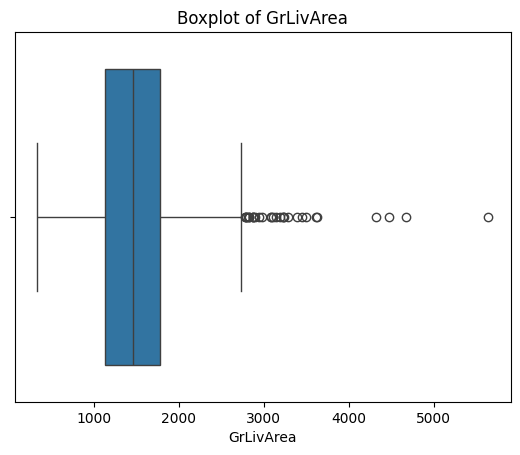

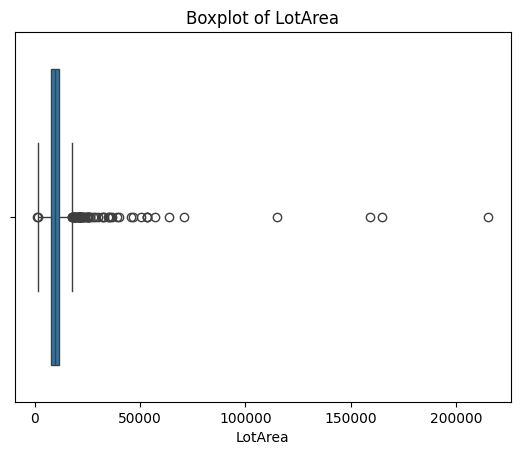


Outlier plots AFTER removal:


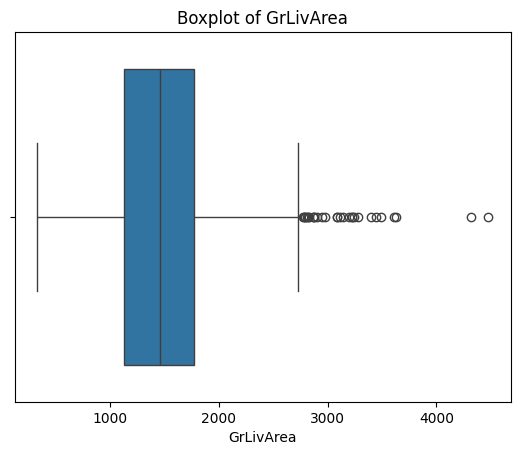

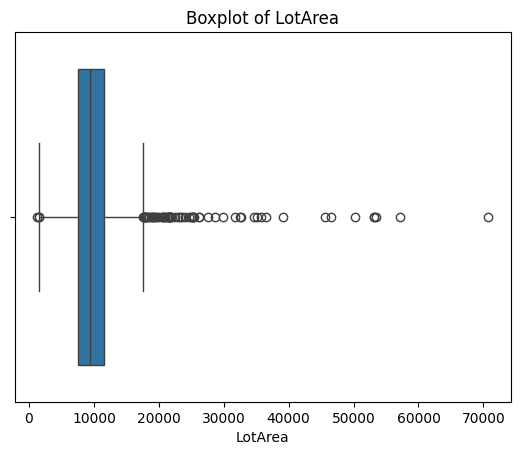

In [4]:
# --- Outlier removal ---
def plot_outliers(df, column):
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

print("\nOutlier plots BEFORE removal:")
for col in ["GrLivArea", "LotArea"]:
    plot_outliers(train, col)

train_clean = train[(train["GrLivArea"] < 4500) & (train["LotArea"] < 100000)]#Remove extreme outliers in these columns

print("\nOutlier plots AFTER removal:")
for col in ["GrLivArea", "LotArea"]:
    plot_outliers(train_clean, col)

In [5]:
# === Feature selection ===
#Get numeric columns, excluding the target and ID
numerical_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["Id", "SalePrice"]]
#Select categorical columns with fewer than 10 unique values for one-hot encoding
categorical_cols = [col for col in train_clean.select_dtypes(include='object').columns if train_clean[col].nunique() < 10]

print(f"Using {len(numerical_cols)} numerical and {len(categorical_cols)} categorical columns.")

Using 36 numerical and 35 categorical columns.


In [6]:
# === Preprocessing pipeline ===
#For numerical features: fill missing values with median, then scale
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
#For categorical features: fill missing values with mode, then one-hot encode
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)
#Combine both transformers into a single preprocessing object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [7]:
# === Transform training data ===
X = train_clean[numerical_cols + categorical_cols]#Separate features and target
y = train_clean["SalePrice"]
X_processed = preprocessor.fit_transform(X)#Fit and transform training features

In [8]:
#Extract final feature names
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(categorical_cols)#Get names of all final features
feature_names = numerical_cols + list(cat_features)
X_df = pd.DataFrame(X_processed, columns=feature_names)#Create a new DataFrame with processed data and proper column names


In [9]:
# === Remove constant columns ===
X_df = X_df.loc[:, X_df.nunique() > 1]#Remove constant columns (no variance)

In [10]:
# === Remove multicollinearity (VIF) ===
#Function to compute VIF for each feature (high VIF means multicollinearity)
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)
#Drop features with VIF > 10
vif = calculate_vif(X_df)
high_vif_features = vif[vif["VIF"] > 10]["feature"].tolist()
print(f"\nRemoving {len(high_vif_features)} features due to high VIF.")
X_df.drop(columns=high_vif_features, inplace=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Removing 188 features due to high VIF.


In [12]:
# === Print final columns used ===
print("\nFinal columns used in the model:")
print(X_df.columns.tolist())
print(f"\nTotal number of features used: {len(X_df.columns)}")


Final columns used in the model:
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Total number of features used: 26


In [13]:
# === Train model ===
model = LinearRegression()
model.fit(X_df, y)

LinearRegression()

In [14]:
# === Prepare test data ===
#Apply the same preprocessing steps to the test data
test_X = test[numerical_cols + categorical_cols]
test_X_processed = preprocessor.transform(test_X)
test_df = pd.DataFrame(test_X_processed, columns=feature_names)


In [15]:
# Drop constant and high-VIF columns from test data
#Remove any extra columns and match training features exactly
test_df = test_df.loc[:, test_df.columns.isin(X_df.columns)]
test_df = test_df.reindex(columns=X_df.columns, fill_value=0)

In [16]:
# === Make predictions ===
predictions = model.predict(test_df)

In [17]:
# === Evaluate on training set ===
#Evaluate the model on the training data
train_preds = model.predict(X_df)
mse = mean_squared_error(y, train_preds)
r2 = r2_score(y, train_preds)
print(f"\nModel Evaluation:\nMSE: {mse:.2f}\nR² Score: {r2:.4f}")


Model Evaluation:
MSE: 1168947798.74
R² Score: 0.8141


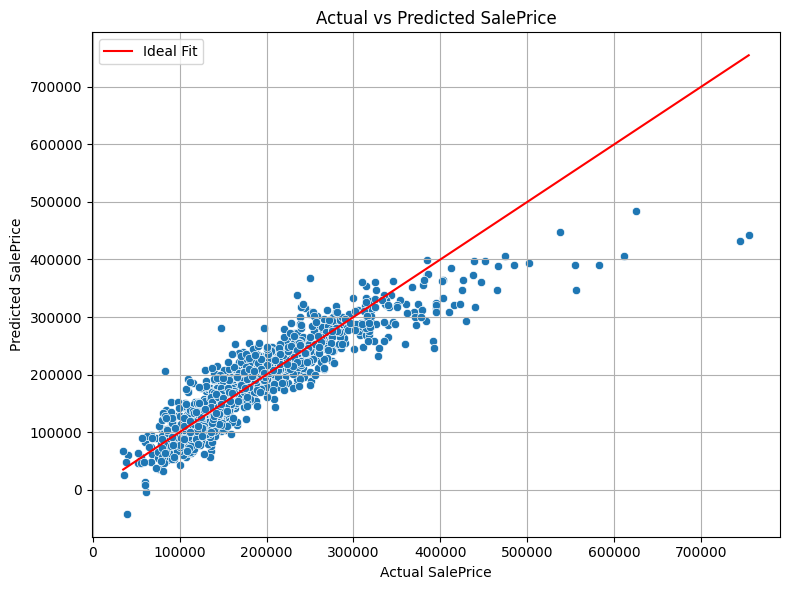

In [18]:
# === Plot actual vs predicted ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=train_preds)
sns.lineplot(x=y, y=y, color='red', label="Ideal Fit")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# === Export predictions ===
submission = pd.DataFrame({
    "Id": test["Id"],
    "PredictedSalePrice": predictions
})
submission.to_csv("submission.csv", index=False)
print("\n Predictions exported to submission.csv")



 Predictions exported to submission.csv
